# 06. Loss Functions and Optimizers

Understanding loss functions and optimizers is crucial for training neural networks effectively. In this notebook, you'll learn about different types of loss functions, various optimization algorithms, and how to choose the right combination for your problem.

By the end of this notebook, you'll understand:

- What loss functions are and why they matter
- Different types of loss functions for various tasks
- How optimizers work and which ones to choose
- How to create custom loss functions
- Learning rate scheduling strategies
- Practical tips for training neural networks

**Why is this important?**

The choice of loss function and optimizer can make the difference between a model that trains successfully and one that fails to converge. Understanding these components will help you debug training issues and achieve better performance.


## What are Loss Functions?

A **loss function** (also called a cost function or objective function) measures how well your model's predictions match the actual targets. The goal of training is to minimize this loss.

### The Role of Loss Functions:

1. **Quantify Error**: Provide a numerical measure of how "wrong" the model is
2. **Guide Training**: The gradients of the loss function tell us how to update model parameters
3. **Enable Comparison**: Allow us to compare different models objectively

### Choosing the Right Loss Function:

- **Regression**: Mean Squared Error, Mean Absolute Error
- **Binary Classification**: Binary Cross-Entropy
- **Multi-class Classification**: Cross-Entropy
- **Multi-label Classification**: Binary Cross-Entropy (per label)

Let's explore these in detail:


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.7.1
Device available: CPU


## Regression Loss Functions

### Mean Squared Error (MSE)

MSE is the most common loss function for regression. It penalizes large errors more heavily than small ones.


MSE (manual calculation): 100.5945
MSE (PyTorch): 100.5945


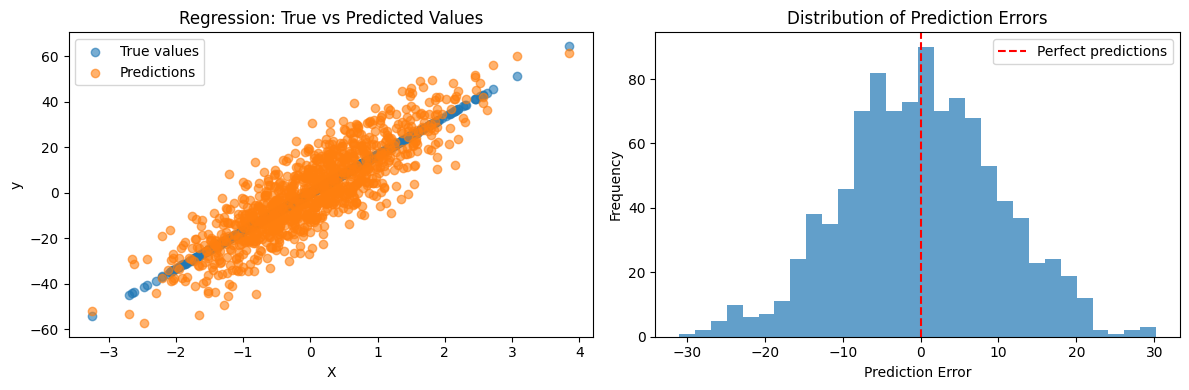

In [15]:
# Create sample regression data
X_reg, y_reg = make_regression(n_samples=1000, n_features=1, noise=0.1, random_state=42)

# Convert to PyTorch tensors
X_reg_tensor = torch.FloatTensor(X_reg)
y_reg_tensor = torch.FloatTensor(y_reg)

# Create some sample predictions (intentionally imperfect)
predictions = y_reg_tensor + torch.randn_like(y_reg_tensor) * 10

# Calculate MSE manually
mse_manual = torch.mean((predictions - y_reg_tensor) ** 2)

# Calculate MSE using PyTorch
mse_loss = nn.MSELoss()
mse_pytorch = mse_loss(predictions, y_reg_tensor)

print(f"MSE (manual calculation): {mse_manual:.4f}")
print(f"MSE (PyTorch): {mse_pytorch:.4f}")

# Visualize the data and predictions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_reg.flatten(), y_reg, alpha=0.6, label="True values")
plt.scatter(
    X_reg.flatten(), predictions.detach().numpy(), alpha=0.6, label="Predictions"
)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Regression: True vs Predicted Values")
plt.legend()

plt.subplot(1, 2, 2)
errors = (predictions - y_reg_tensor).detach().numpy()
plt.hist(errors, bins=30, alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.axvline(x=0, color="red", linestyle="--", label="Perfect predictions")
plt.legend()

plt.tight_layout()
plt.show()

### Mean Absolute Error (MAE)

MAE is more robust to outliers than MSE because it doesn't square the errors.


In [16]:
# Calculate MAE
mae_manual = torch.mean(torch.abs(predictions - y_reg_tensor))

mae_loss = nn.L1Loss()  # L1Loss is MAE in PyTorch
mae_pytorch = mae_loss(predictions, y_reg_tensor)

print(f"MAE (manual calculation): {mae_manual:.4f}")
print(f"MAE (PyTorch): {mae_pytorch:.4f}")


# Compare MSE vs MAE sensitivity to outliers
def compare_loss_sensitivity():
    # Create data with an outlier
    true_values = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

    # Predictions without outlier
    pred_normal = torch.tensor([1.1, 2.1, 2.9, 4.1, 4.9])

    # Predictions with one outlier
    pred_outlier = torch.tensor(
        [1.1, 2.1, 2.9, 4.1, 15.0]
    )  # Last prediction is way off

    mse_normal = F.mse_loss(pred_normal, true_values)
    mae_normal = F.l1_loss(pred_normal, true_values)

    mse_outlier = F.mse_loss(pred_outlier, true_values)
    mae_outlier = F.l1_loss(pred_outlier, true_values)

    print("\nComparison of MSE vs MAE sensitivity to outliers:")
    print(f"Without outlier - MSE: {mse_normal:.4f}, MAE: {mae_normal:.4f}")
    print(f"With outlier    - MSE: {mse_outlier:.4f}, MAE: {mae_outlier:.4f}")
    print(f"MSE increase: {(mse_outlier/mse_normal - 1)*100:.1f}%")
    print(f"MAE increase: {(mae_outlier/mae_normal - 1)*100:.1f}%")
    print("\nNotice how MSE increases much more dramatically with outliers!")


compare_loss_sensitivity()

MAE (manual calculation): 8.0201
MAE (PyTorch): 8.0201

Comparison of MSE vs MAE sensitivity to outliers:
Without outlier - MSE: 0.0100, MAE: 0.1000
With outlier    - MSE: 20.0080, MAE: 2.0800
MSE increase: 199980.3%
MAE increase: 1980.0%

Notice how MSE increases much more dramatically with outliers!


### Smooth L1 Loss (Huber Loss)

Smooth L1 Loss combines the best of both MSE and MAE - it's quadratic for small errors and linear for large errors.


Smooth L1 Loss: 7.5343


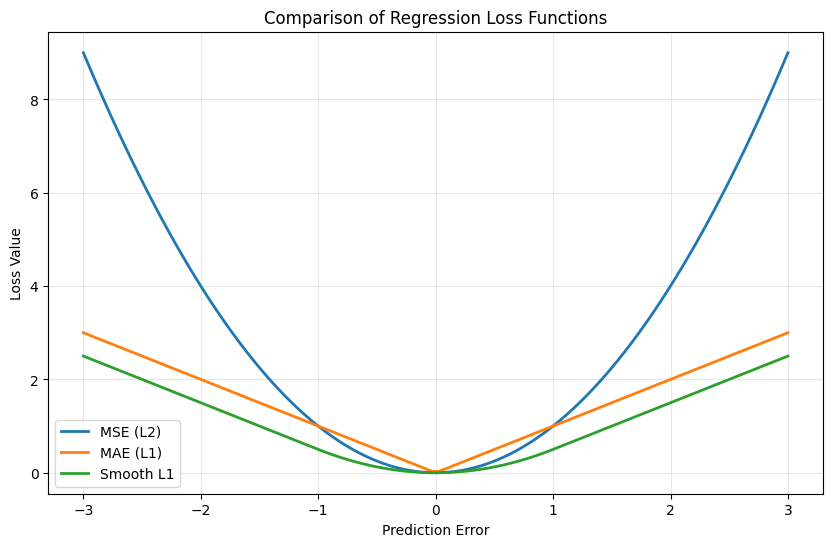

Key observations:
• MSE (L2): Penalizes large errors heavily, smooth gradient
• MAE (L1): Linear penalty, robust to outliers, non-smooth at zero
• Smooth L1: Combines benefits of both - quadratic near zero, linear for large errors


In [17]:
# Smooth L1 Loss
smooth_l1_loss = nn.SmoothL1Loss()
smooth_l1_pytorch = smooth_l1_loss(predictions, y_reg_tensor)

print(f"Smooth L1 Loss: {smooth_l1_pytorch:.4f}")


# Visualize different loss functions
def plot_loss_functions():
    errors = torch.linspace(-3, 3, 100)

    mse_values = errors**2
    mae_values = torch.abs(errors)

    # Smooth L1 loss (Huber loss) calculation
    beta = 1.0  # Default beta for SmoothL1Loss
    smooth_l1_values = torch.where(
        torch.abs(errors) < beta, 0.5 * errors**2 / beta, torch.abs(errors) - 0.5 * beta
    )

    plt.figure(figsize=(10, 6))
    plt.plot(errors.numpy(), mse_values.numpy(), label="MSE (L2)", linewidth=2)
    plt.plot(errors.numpy(), mae_values.numpy(), label="MAE (L1)", linewidth=2)
    plt.plot(errors.numpy(), smooth_l1_values.numpy(), label="Smooth L1", linewidth=2)

    plt.xlabel("Prediction Error")
    plt.ylabel("Loss Value")
    plt.title("Comparison of Regression Loss Functions")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("Key observations:")
    print("• MSE (L2): Penalizes large errors heavily, smooth gradient")
    print("• MAE (L1): Linear penalty, robust to outliers, non-smooth at zero")
    print(
        "• Smooth L1: Combines benefits of both - quadratic near zero, linear for large errors"
    )


plot_loss_functions()

## Classification Loss Functions

### Binary Cross-Entropy

Used for binary classification problems where each sample belongs to one of two classes.


Binary Cross-Entropy (PyTorch): 1.1020
Binary Cross-Entropy (manual): 1.1020


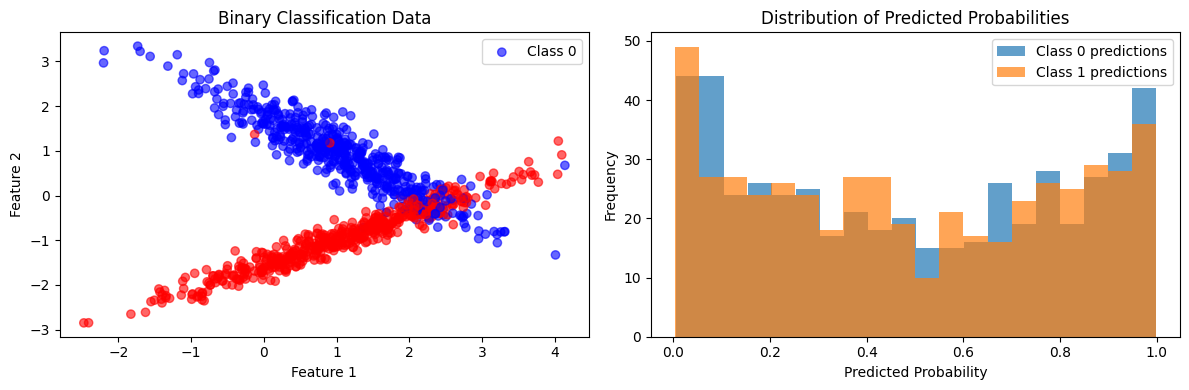

In [18]:
# Create binary classification data
X_binary, y_binary = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    random_state=42,
)

X_binary_tensor = torch.FloatTensor(X_binary)
y_binary_tensor = torch.FloatTensor(y_binary)

# Create some sample predictions (probabilities between 0 and 1)
# Using sigmoid to ensure outputs are between 0 and 1
raw_predictions = torch.randn(1000) * 2  # Random predictions
binary_predictions = torch.sigmoid(raw_predictions)

# Binary Cross-Entropy Loss
bce_loss = nn.BCELoss()
bce_value = bce_loss(binary_predictions, y_binary_tensor)

# Manual calculation of binary cross-entropy
epsilon = 1e-8  # Small value to prevent log(0)
bce_manual = -torch.mean(
    y_binary_tensor * torch.log(binary_predictions + epsilon)
    + (1 - y_binary_tensor) * torch.log(1 - binary_predictions + epsilon)
)

print(f"Binary Cross-Entropy (PyTorch): {bce_value:.4f}")
print(f"Binary Cross-Entropy (manual): {bce_manual:.4f}")

# Visualize the data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
colors = ["red" if label == 0 else "blue" for label in y_binary]
plt.scatter(X_binary[:, 0], X_binary[:, 1], c=colors, alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Binary Classification Data")
plt.legend(["Class 0", "Class 1"])

plt.subplot(1, 2, 2)
plt.hist(
    binary_predictions[y_binary_tensor == 0].detach().numpy(),
    alpha=0.7,
    label="Class 0 predictions",
    bins=20,
)
plt.hist(
    binary_predictions[y_binary_tensor == 1].detach().numpy(),
    alpha=0.7,
    label="Class 1 predictions",
    bins=20,
)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.legend()

plt.tight_layout()
plt.show()

### Cross-Entropy for Multi-class Classification

Used when each sample belongs to exactly one of multiple classes.


Cross-Entropy (PyTorch): 2.1153
Cross-Entropy (manual): 2.1153
Accuracy: 0.3060


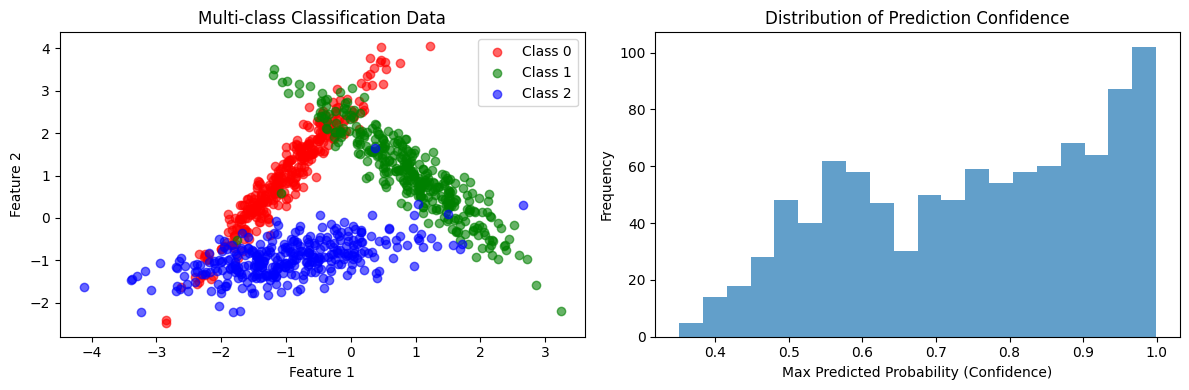

In [19]:
# Create multi-class classification data
X_multi, y_multi = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    n_classes=3,
    random_state=42,
)

X_multi_tensor = torch.FloatTensor(X_multi)
y_multi_tensor = torch.LongTensor(y_multi)  # Note: LongTensor for class indices

# Create sample predictions (logits - raw scores before softmax)
num_classes = 3
logits = torch.randn(1000, num_classes) * 2

# Cross-Entropy Loss (includes softmax)
ce_loss = nn.CrossEntropyLoss()
ce_value = ce_loss(logits, y_multi_tensor)

# Manual calculation of cross-entropy
# First apply softmax to get probabilities
probabilities = F.softmax(logits, dim=1)
# Then calculate cross-entropy
ce_manual = F.nll_loss(torch.log(probabilities), y_multi_tensor)

print(f"Cross-Entropy (PyTorch): {ce_value:.4f}")
print(f"Cross-Entropy (manual): {ce_manual:.4f}")

# Calculate accuracy
predicted_classes = torch.argmax(logits, dim=1)
accuracy = (predicted_classes == y_multi_tensor).float().mean()
print(f"Accuracy: {accuracy:.4f}")

# Visualize the multi-class data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
colors = ["red", "green", "blue"]
for i in range(3):
    mask = y_multi == i
    plt.scatter(
        X_multi[mask, 0], X_multi[mask, 1], c=colors[i], alpha=0.6, label=f"Class {i}"
    )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Multi-class Classification Data")
plt.legend()

plt.subplot(1, 2, 2)
# Show confidence of predictions
max_probs, _ = torch.max(probabilities, dim=1)
plt.hist(max_probs.detach().numpy(), bins=20, alpha=0.7)
plt.xlabel("Max Predicted Probability (Confidence)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Confidence")

plt.tight_layout()
plt.show()

## Custom Loss Functions

Sometimes you need to create custom loss functions for specific problems. Here are some examples:


In [20]:
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    Focuses learning on hard examples by down-weighting easy examples.
    """

    def __init__(self, alpha=1.0, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Calculate cross-entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")

        # Calculate probabilities
        pt = torch.exp(-ce_loss)

        # Calculate focal loss
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss


class DiceLoss(nn.Module):
    """
    Dice Loss for segmentation tasks.
    Measures overlap between predicted and true segmentation masks.
    """

    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid to inputs to get probabilities
        inputs = torch.sigmoid(inputs)

        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate intersection and union
        intersection = (inputs * targets).sum()
        dice_score = (2.0 * intersection + self.smooth) / (
            inputs.sum() + targets.sum() + self.smooth
        )

        return 1 - dice_score


class WeightedMSELoss(nn.Module):
    """
    Weighted MSE Loss where different samples have different importance.
    """

    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, inputs, targets, weights):
        # Calculate MSE for each sample
        mse = (inputs - targets) ** 2

        # Apply weights
        weighted_mse = weights * mse

        return weighted_mse.mean()


# Test the custom loss functions
print("Testing custom loss functions:")

# Test Focal Loss
focal_loss = FocalLoss(alpha=1.0, gamma=2.0)
focal_value = focal_loss(logits, y_multi_tensor)
print(f"Focal Loss: {focal_value:.4f}")

# Test Dice Loss
dice_loss = DiceLoss()
# Create fake segmentation data
pred_mask = torch.randn(10, 1, 32, 32)
true_mask = torch.randint(0, 2, (10, 1, 32, 32)).float()
dice_value = dice_loss(pred_mask, true_mask)
print(f"Dice Loss: {dice_value:.4f}")

# Test Weighted MSE Loss
weighted_mse = WeightedMSELoss()
sample_weights = torch.rand(1000)  # Random weights for each sample
weighted_mse_value = weighted_mse(predictions, y_reg_tensor, sample_weights)
print(f"Weighted MSE Loss: {weighted_mse_value:.4f}")

Testing custom loss functions:
Focal Loss: 1.7863
Dice Loss: 0.5059
Weighted MSE Loss: 49.6728


## Optimizers

Optimizers determine how model parameters are updated based on the gradients of the loss function.

### Stochastic Gradient Descent (SGD)

The most basic optimizer - updates parameters in the direction opposite to the gradient.


In [21]:
# Create a simple model for demonstration
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize models for different optimizers
model_sgd = SimpleModel(2, 10, 3)
model_adam = SimpleModel(2, 10, 3)
model_rmsprop = SimpleModel(2, 10, 3)

# Copy the same initial weights to all models for fair comparison
with torch.inference_mode():
    for param_adam, param_rmsprop, param_sgd in zip(
        model_adam.parameters(), model_rmsprop.parameters(), model_sgd.parameters()
    ):
        param_adam.copy_(param_sgd)
        param_rmsprop.copy_(param_sgd)

# Define optimizers
learning_rate = 0.01

# SGD - Basic gradient descent
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=learning_rate)

# SGD with momentum - Helps accelerate SGD in relevant directions
optimizer_sgd_momentum = optim.SGD(
    model_sgd.parameters(), lr=learning_rate, momentum=0.9
)

# Adam - Adaptive learning rates with momentum
optimizer_adam = optim.Adam(model_adam.parameters(), lr=learning_rate)

# RMSprop - Adaptive learning rates
optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=learning_rate)

print("Optimizers created:")
print(f"SGD: lr={learning_rate}")
print(f"SGD with Momentum: lr={learning_rate}, momentum=0.9")
print(f"Adam: lr={learning_rate}, betas=(0.9, 0.999)")
print(f"RMSprop: lr={learning_rate}, alpha=0.99")

Optimizers created:
SGD: lr=0.01
SGD with Momentum: lr=0.01, momentum=0.9
Adam: lr=0.01, betas=(0.9, 0.999)
RMSprop: lr=0.01, alpha=0.99


### Comparing Different Optimizers

Let's train the same model with different optimizers and compare their convergence:


Training models with different optimizers...


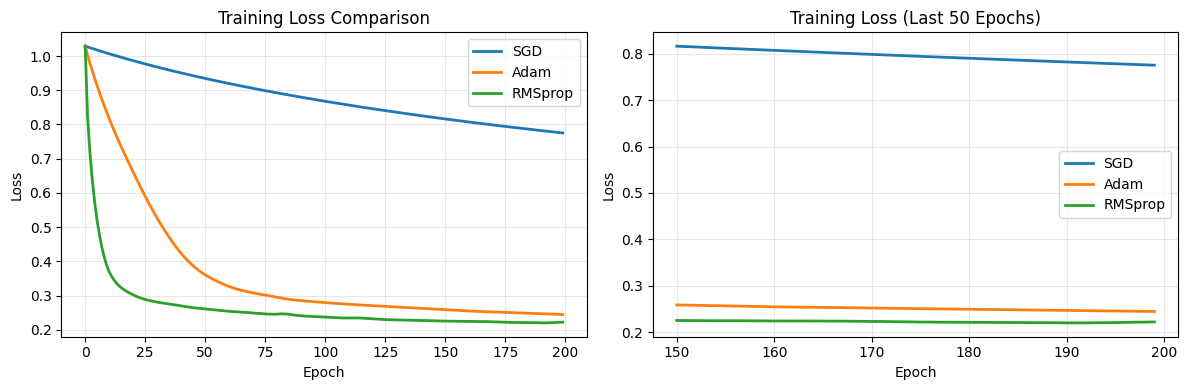

Final losses:
SGD: 0.7751
Adam: 0.2447
RMSprop: 0.2222


In [22]:
def train_with_optimizer(model, optimizer, X, y, epochs=100):
    """
    Train a model with a specific optimizer and return loss history.
    """
    model.train()
    loss_history = []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

    return loss_history


# Prepare data
X_train = X_multi_tensor[:800]  # First 800 samples for training
y_train = y_multi_tensor[:800]

# Train models with different optimizers
print("Training models with different optimizers...")

# Reset models to same initial state
model_sgd = SimpleModel(2, 10, 3)
model_adam = SimpleModel(2, 10, 3)
model_rmsprop = SimpleModel(2, 10, 3)

# Copy initial weights
with torch.inference_mode():
    for param_adam, param_rmsprop, param_sgd in zip(
        model_adam.parameters(), model_rmsprop.parameters(), model_sgd.parameters()
    ):
        param_adam.copy_(param_sgd)
        param_rmsprop.copy_(param_sgd)

# Create optimizers
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.01)
optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=0.01)

# Train models
epochs = 200
loss_sgd = train_with_optimizer(model_sgd, optimizer_sgd, X_train, y_train, epochs)
loss_adam = train_with_optimizer(model_adam, optimizer_adam, X_train, y_train, epochs)
loss_rmsprop = train_with_optimizer(
    model_rmsprop, optimizer_rmsprop, X_train, y_train, epochs
)

# Plot convergence comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_sgd, label="SGD", linewidth=2)
plt.plot(loss_adam, label="Adam", linewidth=2)
plt.plot(loss_rmsprop, label="RMSprop", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Plot last 50 epochs for better detail
start_epoch = 150
plt.plot(range(start_epoch, epochs), loss_sgd[start_epoch:], label="SGD", linewidth=2)
plt.plot(range(start_epoch, epochs), loss_adam[start_epoch:], label="Adam", linewidth=2)
plt.plot(
    range(start_epoch, epochs), loss_rmsprop[start_epoch:], label="RMSprop", linewidth=2
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (Last 50 Epochs)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final losses:")
print(f"SGD: {loss_sgd[-1]:.4f}")
print(f"Adam: {loss_adam[-1]:.4f}")
print(f"RMSprop: {loss_rmsprop[-1]:.4f}")

## Learning Rate Scheduling

Learning rate scheduling can significantly improve training performance by adjusting the learning rate during training.


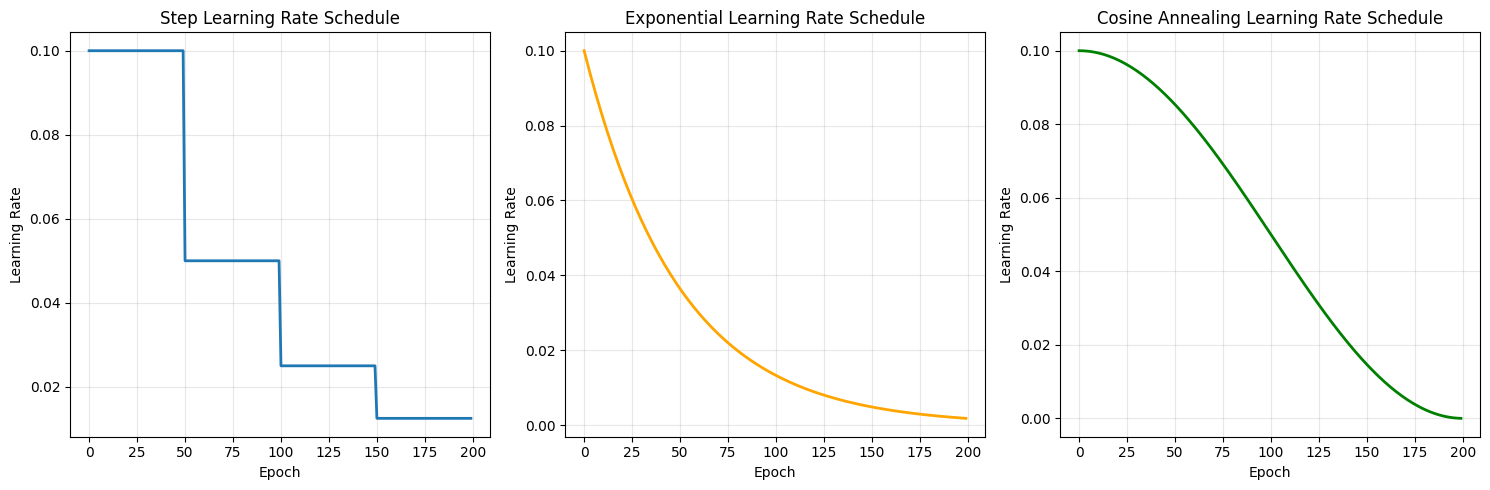

Learning Rate Scheduling Strategies:

1. Step LR: Reduces LR by a factor at fixed intervals
   • Good for: When you know roughly when to reduce LR
   • Use case: Standard training with known convergence points

2. Exponential LR: Gradually decreases LR each epoch
   • Good for: Smooth decay over time
   • Use case: When you want gradual refinement

3. Cosine Annealing: Smooth cosine decay with restarts
   • Good for: Escaping local minima
   • Use case: When training might get stuck in poor solutions


In [23]:
# Create a model for learning rate scheduling demonstration
model_scheduler = SimpleModel(2, 10, 3)
optimizer = optim.SGD(model_scheduler.parameters(), lr=0.1)  # Start with higher LR

# Different types of schedulers
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
scheduler_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


def train_with_scheduler(model, optimizer, scheduler, X, y, epochs=100):
    """
    Train model with learning rate scheduler.
    """
    model.train()
    loss_history = []
    lr_history = []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update learning rate
        scheduler.step()

        loss_history.append(loss.item())
        lr_history.append(optimizer.param_groups[0]["lr"])

    return loss_history, lr_history


# Demonstrate different learning rate schedules
epochs = 200
lrs = torch.linspace(0, epochs - 1, epochs)

# Step LR: reduces LR by factor every step_size epochs
step_lrs = [0.1 * (0.5 ** (epoch // 50)) for epoch in range(epochs)]

# Exponential LR: multiplies LR by gamma each epoch
exp_lrs = [0.1 * (0.98**epoch) for epoch in range(epochs)]

# Cosine Annealing: cosine decay
cosine_lrs = [
    0.1 * 0.5 * (1 + np.cos(np.pi * epoch / epochs)) for epoch in range(epochs)
]

# Plot different learning rate schedules
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(step_lrs, label="Step LR", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Step Learning Rate Schedule")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(exp_lrs, label="Exponential LR", linewidth=2, color="orange")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Learning Rate Schedule")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(cosine_lrs, label="Cosine LR", linewidth=2, color="green")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Cosine Annealing Learning Rate Schedule")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Learning Rate Scheduling Strategies:")
print("\n1. Step LR: Reduces LR by a factor at fixed intervals")
print("   • Good for: When you know roughly when to reduce LR")
print("   • Use case: Standard training with known convergence points")

print("\n2. Exponential LR: Gradually decreases LR each epoch")
print("   • Good for: Smooth decay over time")
print("   • Use case: When you want gradual refinement")

print("\n3. Cosine Annealing: Smooth cosine decay with restarts")
print("   • Good for: Escaping local minima")
print("   • Use case: When training might get stuck in poor solutions")

## Advanced Optimizer Concepts

### Understanding Adam Optimizer

Adam combines momentum with adaptive learning rates. Let's understand how it works:


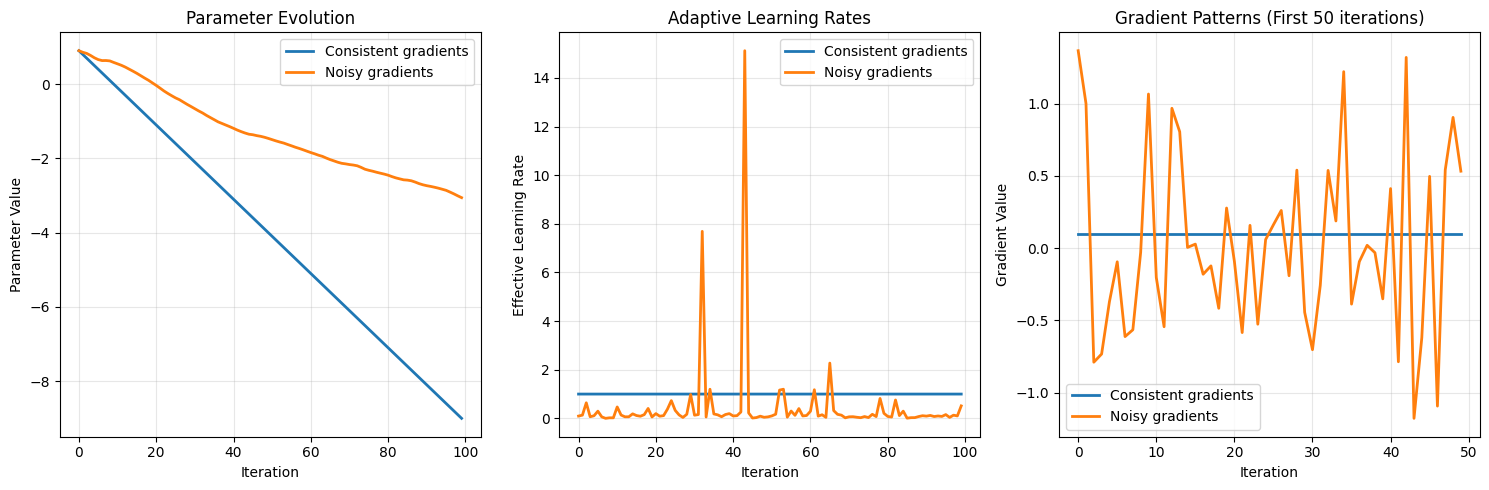

Key Observations:
• Adam adapts learning rates based on gradient history
• Parameters with noisy gradients get smaller effective learning rates
• Parameters with consistent gradients can use larger effective learning rates
• This helps with convergence in high-dimensional optimization


In [24]:
class CustomAdam:
    """
    A simplified implementation of Adam optimizer to understand its mechanics.
    """

    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0  # Time step

        # Initialize moment estimates
        self.m = [torch.zeros_like(p) for p in self.params]  # First moment
        self.v = [torch.zeros_like(p) for p in self.params]  # Second moment

    def step(self):
        self.t += 1

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data

            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad

            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad**2

            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - self.beta1**self.t)

            # Compute bias-corrected second raw moment estimate
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            # Update parameters
            param.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data.zero_()


# Demonstrate Adam's adaptive learning rates
def visualize_adam_adaptation():
    """
    Visualize how Adam adapts learning rates for different parameters.
    """
    # Create a simple parameter (just a single value for visualization)
    param1 = torch.tensor(
        [1.0], requires_grad=True
    )  # Parameter with consistent gradients
    param2 = torch.tensor([1.0], requires_grad=True)  # Parameter with noisy gradients

    # Initialize Adam optimizer
    adam_opt = CustomAdam([param1, param2], lr=0.1)

    # Track adaptation
    iterations = 100
    param1_values = []
    param2_values = []
    effective_lr1 = []
    effective_lr2 = []

    for i in range(iterations):
        # Simulate gradients
        # param1 gets consistent gradients
        param1.grad = torch.tensor([0.1])

        # param2 gets noisy gradients
        noise = torch.randn(1) * 0.5
        param2.grad = torch.tensor([0.1]) + noise

        # Store values before update
        old_param1 = param1.data.clone()
        old_param2 = param2.data.clone()

        # Update
        adam_opt.step()

        # Calculate effective learning rates
        eff_lr1 = abs(param1.data - old_param1) / abs(param1.grad.data)
        eff_lr2 = abs(param2.data - old_param2) / abs(param2.grad.data)

        param1_values.append(param1.item())
        param2_values.append(param2.item())
        effective_lr1.append(eff_lr1.item())
        effective_lr2.append(eff_lr2.item())

    # Plot results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(param1_values, label="Consistent gradients", linewidth=2)
    plt.plot(param2_values, label="Noisy gradients", linewidth=2)
    plt.xlabel("Iteration")
    plt.ylabel("Parameter Value")
    plt.title("Parameter Evolution")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(effective_lr1, label="Consistent gradients", linewidth=2)
    plt.plot(effective_lr2, label="Noisy gradients", linewidth=2)
    plt.xlabel("Iteration")
    plt.ylabel("Effective Learning Rate")
    plt.title("Adaptive Learning Rates")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    gradients1 = [0.1] * iterations
    gradients2 = [0.1 + torch.randn(1).item() * 0.5 for _ in range(iterations)]
    plt.plot(gradients1[:50], label="Consistent gradients", linewidth=2)
    plt.plot(gradients2[:50], label="Noisy gradients", linewidth=2)
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Value")
    plt.title("Gradient Patterns (First 50 iterations)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Key Observations:")
    print("• Adam adapts learning rates based on gradient history")
    print("• Parameters with noisy gradients get smaller effective learning rates")
    print(
        "• Parameters with consistent gradients can use larger effective learning rates"
    )
    print("• This helps with convergence in high-dimensional optimization")


visualize_adam_adaptation()

## Practical Training Tips

Here are some practical guidelines for choosing loss functions and optimizers:


# 🚀 PyTorch Training Checklist 🚀

## 📋 Problem Type

### 📌 Regression

**Loss Functions:**

- **MSE**: When you want to penalize large errors heavily
- **MAE**: When you have outliers or want robust training
- **Smooth L1**: Best of both worlds - smooth gradients, robust to outliers
- **Huber**: Similar to Smooth L1, good for robust regression

**Optimizers:**

- **Adam**: Good default choice, works well in most cases
- **SGD+Momentum**: When you have time to tune, often achieves better final performance
- **RMSprop**: Good for RNNs and noisy gradients

### 📌 Binary Classification

**Loss Functions:**

- **BCE**: Standard choice for binary classification
- **Focal Loss**: When dealing with class imbalance
- **Weighted BCE**: Simple way to handle class imbalance

**Optimizers:** Same as regression

### 📌 Multi-class Classification

**Loss Functions:**

- **Cross-Entropy**: Standard choice, includes softmax
- **Focal Loss**: For imbalanced datasets
- **Label Smoothing**: Helps with overconfident predictions

**Optimizers:** Same as regression

## 📋 Learning Rate Guidelines

### 📌 Starting Points

- **Adam**: 0.001 (1e-3) is a good default
- **SGD**: 0.01 to 0.1, often needs momentum (0.9)
- **RMSprop**: 0.001 to 0.01

### 📌 How to Tune

- Start with default values
- If training is slow, increase LR
- If loss explodes, decrease LR
- Use learning rate schedules for fine-tuning

## 📋 Common Issues

### 📌 Loss Not Decreasing

- Learning rate too low
- Wrong loss function
- Data preprocessing issues
- Model too simple

### 📌 Loss Exploding

- Learning rate too high
- Gradient clipping might help
- Check for NaN values in data
- Batch normalization can help

### 📌 Slow Convergence

- Try Adam instead of SGD
- Increase learning rate
- Use learning rate scheduling
- Check data normalization


## Summary

In this comprehensive notebook, you've learned about loss functions and optimizers - two critical components of neural network training:

### Key Takeaways:

**Loss Functions:**

- Choose based on your problem type (regression vs classification)
- Consider robustness to outliers (MAE vs MSE)
- Handle class imbalance with weighted losses or Focal Loss
- Custom loss functions can be created for specific needs

**Optimizers:**

- Adam is a good default choice for most problems
- SGD with momentum can achieve better final performance with tuning
- Different optimizers converge at different rates
- Learning rate scheduling can significantly improve training

**Best Practices:**

1. Start with standard combinations (Adam + appropriate loss)
2. Monitor training curves to diagnose issues
3. Use learning rate schedules for fine-tuning
4. Consider the specific challenges of your problem (imbalance, outliers, etc.)
5. Don't be afraid to experiment with custom loss functions

### What's Next?

With a solid understanding of loss functions and optimizers, you're ready to tackle more advanced topics like:

- Regularization techniques
- Advanced architectures
- Transfer learning
- Model deployment

Remember: The art of deep learning often lies in choosing the right combination of loss function, optimizer, and hyperparameters for your specific problem!
